## Семинар 10: "Генерация текстов"

ФИО: Полыковский Даниил Александрович

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [98]:
! head -n 2 author-quote.txt

A. A. Milne	If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
A. A. Milne	Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.


In [99]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

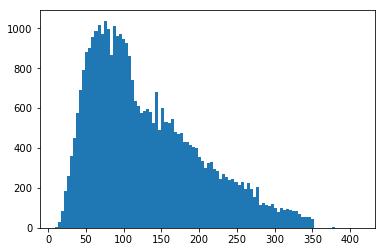

In [100]:
plt.hist(map(len, lines), bins=100);

In [101]:
line = lines[11]

In [102]:
line

'One of the advantages of being disorderly is that one is constantly making exciting discoveries.'

In [103]:
lines = filter(lambda x: len(x) <= 50, lines)

In [104]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)
        

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [105]:
vocab = Vocabulary(lines)

In [106]:
vocab.size

75

In [107]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [108]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [109]:
dataset = Quotes(lines, vocab)

In [110]:
dataloader = DataLoader(dataset, shuffle=True)

### Часть 2: определение модели

In [113]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=50):
        h = Variable(torch.Tensor(self.layers, 1, self.hidden_size).normal_(), requires_grad=False)*0
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            new_token_id = np.argmax(classes.data.numpy())
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [114]:
oracle = Oracle(vocab.size, embedding_size=128, hidden_size=256, layers=1)

### Часть 3: обучение модели

In [115]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)

In [116]:
criterion = nn.CrossEntropyLoss()

In [117]:
losses = []

In [118]:
for epoch in tqdm.tqdm(xrange(1000)):
    bar = progressbar.ProgressBar()
    
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i%32 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            print loss.data[0], oracle.generate(vocab)

  0%|          | 0/1000 [00:00<?, ?it/s]

4.34620046616 Conquer,  t t t t t t t t t t t t t t t t t t t t 
4.03282737732 Con t  t    t     t     t     t     t     t     t 
3.21023035049 I oneeereeereeereeereeereeereeereeereeereeereeeree
3.08896446228 I ansss.<eos>
2.91508030891 I allline alline allline alline allline alline all
2.40798807144 I the to the tore tore tore tore tore tore tore to
2.74886322021 I the to to to to to to to to to to to to to to to
2.21255111694 I the the the the the the the the the to the the t
2.3000998497 I an the an the an the an the an the an the an the
2.33908605576 I'm an ang ang ang ang ang ang ang ang ang ang ang
2.50449705124 I'm and and ang and ang ang and ang ang ang ang an
1.99529409409 I'm a le all all all all all ally and is and is an
2.30130910873 Whe is se is se is se is se is se is se is se is s
2.57564973831 I he is son is son is son is son is son is son is 
2.29140877724 I hof the in the in the in the in the in the in th
2.44019579887 I a be ar the a the ar the ar the ar the ar the a

  0%|          | 1/1000 [06:45<112:29:31, 405.38s/it]

1.70173752308 I don't the to be to be to be to be to be the be a
1.55716586113 I don't the to be to be to be to be to be to be to
2.39717912674 I don't the be a can of the be a can of the be a c
2.24338364601 I don't the was a can a but the was a can a can a 
2.03453397751 I don't was a can and I am a can and I am a can an
1.74268496037 I don't win should be a be an and I am a but a can
1.62136113644 I don't have a be an one the passion of a good the
1.6836540699 I'm a past and I am a good the people the people.<eos>
1.73562204838 I'm a compassion is the people.<eos>
1.65840530396 I'm a lot of the proment of the people the people 
1.94950246811 I don't like the work with life to be a lot of the
1.26132106781 I don't like the work win with life.<eos>
2.20607829094 I don't like the work win win win win win win win 
1.38567912579 I don't like to be a love being a lot of the work.
1.56911301613 I don't the been bean being a work.<eos>
1.75234496593 I don't the believe the beate the beate t

  0%|          | 2/1000 [13:18<110:42:43, 399.36s/it]

1.83954203129 I am a spart of pretty is a show I have a such of 
1.66697144508 I am a spart of pretty.<eos>
1.71996068954 I am a spart a spart a girl.<eos>
2.02933597565 I am a spart a will with a spart.<eos>
1.68651163578 I am a will with a will with a woman.<eos>
1.45513689518 I am a work and I want to make to many.<eos>
1.48870933056 I like to the world it in the world.<eos>
1.68888878822 I love to the to to to to to to to to to to to to 
1.53022217751 I love the good to the to do.<eos>
1.19624865055 I don't have the the the the the the the the the t
1.61190164089 I don't have a people and I don't have the really.
1.28155219555 I don't have a started the really the really.<eos>
1.26655471325 I don't have a started to day a star.<eos>
1.25089943409 I don't have a past a past a past a part and a suc
1.41307806969 I don't have a past and a paint of a big the only 
1.41937398911 I love and be a pasing and be and be a more.<eos>
1.89218664169 I love to be a more to be a more.<eos>
1.1955

  0%|          | 3/1000 [19:41<109:06:53, 394.00s/it]

1.06891560555 I love a good to love a life I love a good to be a
1.76630175114 I love a good to be a moration.<eos>
1.87262141705 I like to love a man is a good to be.<eos>
1.48143053055 I like a great a contry it.<eos>
1.32732176781 I like a controm a contry.<eos>
1.77999138832 I like a contry in the best the best.<eos>
1.46744310856 I am a contry in the best the best the best the be
1.41868627071 I don't want to be a pretty in the best the best t
1.41373586655 I don't want to be a pret to be a preced.<eos>
1.09394323826 I don't want to be a pretty controm to be a part.<eos>
1.52953767776 I don't want to be a preced up to be a part.<eos>
1.79872512817 I want to be a precenture to be a passion.<eos>
1.36779868603 I don't want to be a precenture.<eos>
1.44829940796 I don't know I'm a will find of the best.<eos>
1.16985845566 I am a fine for find of for for for 10 you can.<eos>
1.50307369232 I am a fine for for 10 you can.<eos>
1.44662821293 I am a big for the best is a proble.<eos>
1.18

  0%|          | 4/1000 [26:26<109:42:48, 396.55s/it]

1.37567424774 I don't like a good a good of a good.<eos>
1.63630628586 I don't like a good only life.<eos>
1.18670475483 I don't like the difer.<eos>
1.34119081497 I don't had the good that I do not the diferact.<eos>
1.38792729378 I don't have to be a great to be a great to be a g
1.55357587337 I do not to be a great to be a great to be a great
1.70382714272 I do not to be a great to me a great art as all.<eos>
1.52494931221 I was a people art as a part.<eos>
2.01821327209 I want to man is a part and to be a part.<eos>
1.39450883865 I want to man is a part.<eos>
1.31354367733 I want to me a part.<eos>
1.05456376076 I have a work for the man in the speed.<eos>
1.48802018166 I have a chect of my favories.<eos>
1.28335487843 I love to do on the speed of the sparing.<eos>
1.54272842407 I love to do on the speed of the sparine.<eos>
1.26598274708 I love the spart of the spart.<eos>
1.2396235466 I love the spare a die the girls and I am a passio
1.52764976025 I love the part of a great and 

KeyboardInterrupt: 

In [119]:
oracle.generate(vocab)

'I live in the world you want to be real.<eos>'

In [137]:
a = Vocabulary([''])

In [138]:
oracle.generate(a)

KeyError: 51

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

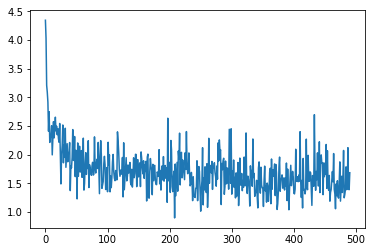

In [122]:
plt.plot(losses)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: